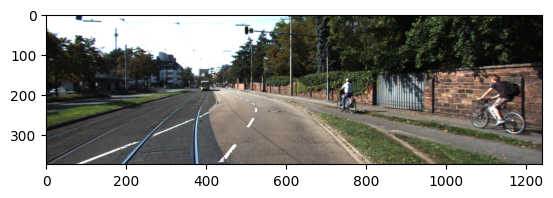

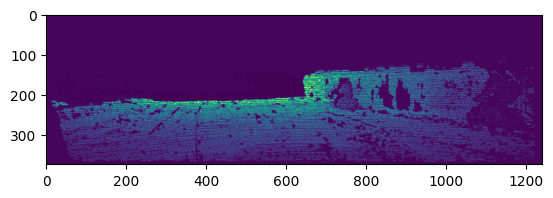

In [1]:
from Dataloader.kitti_data_loader import get_kitti_loader
import torch
from matplotlib import pyplot as plt

kitti_loader = get_kitti_loader(data_dir_root='./Dataloader/kitti/', split='test')
sample = next(iter(kitti_loader))
kitti_img = sample['image']
kitti_depth = sample['depth']

plt.imshow(torch.permute(kitti_img, (2, 3, 1, 0)).squeeze())
plt.show()
plt.imshow(torch.permute(kitti_depth, (2, 3, 1, 0)).squeeze())
plt.show()

odict_keys(['encoder.layers.layer0.0.weight', 'encoder.layers.layer0.0.bias', 'encoder.layers.layer0.2.weight', 'encoder.layers.layer0.2.bias', 'encoder.layers.layer1.5.weight', 'encoder.layers.layer1.5.bias', 'encoder.layers.layer1.7.weight', 'encoder.layers.layer1.7.bias', 'encoder.layers.layer2.10.weight', 'encoder.layers.layer2.10.bias', 'encoder.layers.layer2.12.weight', 'encoder.layers.layer2.12.bias', 'encoder.layers.layer2.14.weight', 'encoder.layers.layer2.14.bias', 'encoder.layers.layer2.16.weight', 'encoder.layers.layer2.16.bias', 'encoder.layers.layer3.19.weight', 'encoder.layers.layer3.19.bias', 'decoder.layers.layer0.0.weight', 'decoder.layers.layer0.0.bias', 'decoder.layers.layer0.2.weight', 'decoder.layers.layer0.2.bias', 'decoder.layers.layer1.0.weight', 'decoder.layers.layer1.0.bias', 'decoder.layers.layer1.2.weight', 'decoder.layers.layer1.2.bias', 'decoder.layers.layer2.0.weight', 'decoder.layers.layer2.0.bias', 'decoder.layers.layer2.2.weight', 'decoder.layers.laye

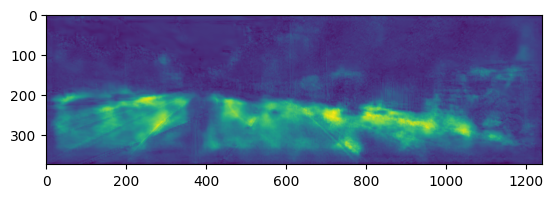

In [18]:
from Models.AutoEncoder import AutoEncoder

model = AutoEncoder()
with open('./Models/ckpt/autoencoder_tune.pt', 'rb') as f:
    weights = torch.load(f)
    model.load_state_dict(weights)
    print(model.state_dict().keys())
    print(weights.keys())
model = model.eval()

with torch.no_grad():
    pred_depth = model(kitti_img)
    pred_depth *= 80
    
plt.imshow(torch.permute(pred_depth, (2, 3, 1, 0)).squeeze())
plt.show()

In [19]:
import open3d as o3d
import numpy as np
depth_for_o3d = torch.permute(kitti_depth, (2, 3, 1, 0)).squeeze(-1).numpy()
pred_depth_for_o3d = torch.permute(pred_depth, (2, 3, 1, 0)).squeeze(-1).numpy()
rgb_img = torch.permute(kitti_img, (2,3,1,0)).squeeze().numpy()

In [20]:
from depthadjust import DepthAdjust
depthadjust = DepthAdjust()
_, _, scale_depth = depthadjust.fit_and_trainsform(pred_depth_for_o3d, depth_for_o3d, icp=False, return_proj=True)
adj_depth, gt, reproject = depthadjust.fit_and_trainsform(pred_depth_for_o3d, depth_for_o3d, icp=True, return_proj=True)

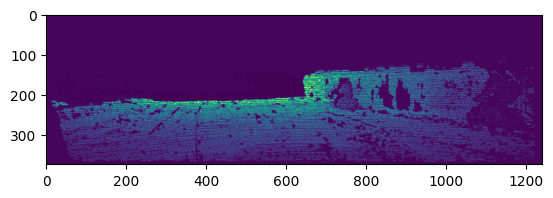

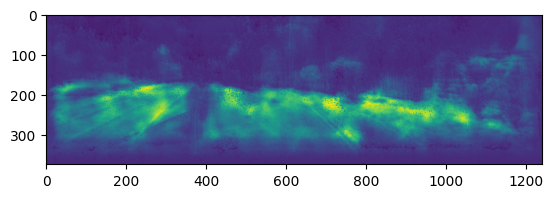

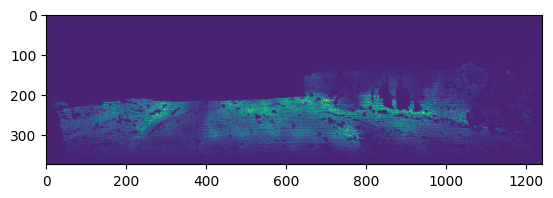

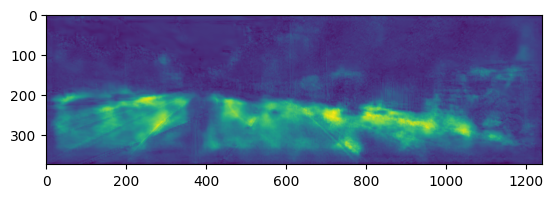

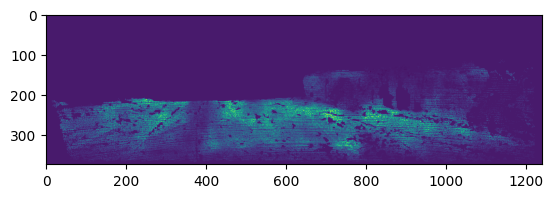

In [21]:
plt.imshow(depth_for_o3d)
plt.show()
plt.imshow(reproject)
plt.show()
plt.imshow(np.where(depth_for_o3d.squeeze()>0, reproject, 0))
plt.show()
plt.imshow(scale_depth)
plt.show()
plt.imshow(np.where(depth_for_o3d.squeeze()>0, scale_depth, 0))
plt.show()


In [17]:
valid_indice = depth_for_o3d > 0
ground_truth = depth_for_o3d[valid_indice]
pred = pred_depth_for_o3d[valid_indice]
adj = adj_depth[valid_indice]

print(((ground_truth - pred)**2).mean())
print(((ground_truth - adj)**2).mean())

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [ ]:
valid_indice = depth_for_o3d > 0
ground_truth = depth_for_o3d[valid_indice]
pred = pred_depth_for_o3d[valid_indice]
adj = adj_depth[valid_indice]

print(((ground_truth - pred)**2).mean())
print(((ground_truth - adj)**2).mean())

In [17]:
import copy
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[0,0,1],
                                      lookat=[0,0,0],
                                      up=[-0.3402, -0.9189, -0.1996])
 

In [27]:
tar_p3d = depthadjust.depth23d(depth_for_o3d)
tar_p3d /= depthadjust.tar_scalef
src_p3d = depthadjust.depth23d(pred_depth_for_o3d)
src_p3d /= depthadjust.src_scalef
p3d = src_p3d[tar_p3d[...,2] > 0]
src_pcd = o3d.geometry.PointCloud()
src_pcd.points = o3d.utility.Vector3dVector(p3d)
tar_pcd = o3d.geometry.PointCloud()
tar_pcd.points = o3d.utility.Vector3dVector(tar_p3d[tar_p3d[...,2] > 0])
# o3d.visualization.draw_geometries([tar_pcd, src_pcd])
o3d.visualization.draw_geometries([src_pcd])

In [18]:
draw_registration_result(src_pcd, tar_pcd, np.eye(4)) #depthadjust.transformation

In [ ]:
threshold = 0.02
# trans_init = np.array([
#     [1,0,0,0],
#     [0,1,0,0],
#     [0,0,1,0],
#     [0,0,0,1]
# ])
reg_p2p = o3d.pipelines.registration.registration_icp(
    src_pcd, tar_pcd, threshold,
    estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint(with_scaling=True)
)

In [ ]:
reg_p2p.transformation

In [ ]:
draw_registration_result(src_pcd, tar_pcd, reg_p2p.transformation)

In [2]:
import numpy as np
idx = np.random.randint(0,10, size=(2))
idx

array([6, 5])

In [4]:
(np.random.random((10)) < 0.5).sum()

4